In [30]:
import plotly.graph_objects as go
import pandas as pd

import matplotlib.pyplot as plt
import networkx as nx

# reading input log file
from statistics import mode
import math
import sys
import traceback
from csv import excel
from collections import Counter
from scipy import stats

path='../save_outputs/vol-vfd'
group_cnt = 5

In [31]:
# data related methods
def humansize(nbytes):
    suffixes = ['B', 'KB', 'MB', 'GB', 'TB', 'PB']
    i = 0
    while nbytes >= 1000 and i < len(suffixes)-1:
        nbytes /= 1000.
        i += 1
    f = ('%.2f' % nbytes).rstrip('0').rstrip('.')
    return '%s %s' % (f, suffixes[i])

def check_empty(df,p=True):
    nan_df = df[df.isna().any(axis=1)].copy()
    if not nan_df.empty:
        if p:
            print(f"NaN rows: {nan_df}") # check any nan
        return list(nan_df.index)
    
    null_df = df[df.isnull().any(axis=1)].copy()
    if not null_df.empty:
        if p:
            print(f"NULL rows: {null_df}") # check any null
        return list(null_df.index)
    
def print_list_diff(list1, list2):
    if list1 == list2:
        print("same lists")
    else:
        print("different lists\nindex:\t[list1]\t[list2]")
        for index, (first, second) in enumerate(zip(list1, list2)):
            if first != second:
                # print(index, first, second)
                print(f"{index}:\t{first}]\t[{second}]")

def df_to_csv(df,file_name,suffix=''):
    # df.hash_id=df.hash_id.astype('category').cat.codes
    # out_csv=file_name.replace('prov-vfd-','')
    out_csv=file_name.replace('.csv',f'{suffix}.csv')
    df.to_csv(out_csv,index=False)
    
def read_data(filename, dset=''):
    if '.parquet' in filename:
        df = pd.read_parquet(filename,engine='pyarrow')
    if'.csv' in filename:
        df = pd.read_csv(filename,index_col=False)
    
    if len(dset) > 0:
        df = df[df['dset_name'] == dset]
        
    return df

In [32]:
# networkx related methods

# color names : https://www.w3schools.com/colors/colors_names.asp
COLOR_MAP = {"task": "FireBrick", # read
            "vol": "Salmon", #orange
            "contact_map": "Tomato", 
            "point_cloud": "OrangeRed", 
            "addr": "SkyBlue", # blue
            # "logical_addr": "SkyBlue", #light blue
            # "logical_addr_vfd": "PowderBlue", # slightly different light lue
            "file": "RoyalBlue", # darker blue
            "none": "grey",
            }

def rm_name_tags(name, tags):
    for t in tags:
        name = str(name).replace(f"{t}-","")
        name = str(name).replace("vol-","")
        name = str(name).replace("contact_map","cm")
        name = str(name).replace("point_cloud","pc")
    return name

def draw_graph(G,color_map=COLOR_MAP, rm_tags=['']):
    pos=nx.get_node_attributes(G,'pos')
    names = nx.get_node_attributes(G,'name')

    node_colors = [] 
    # set node colors
    for name in names.values():
        _n = rm_name_tags(name, rm_tags)
        node_colors.append(color_map[_n])
        
    # set node labels
    labels = {}
    for node in names.keys():
        _n = rm_name_tags(node, rm_tags)
        labels[node] = _n

    plt.figure(figsize=(25, 10)) #figsize=(40, 10)
    
    bbox = dict(alpha=0.6, fc="black", ec="white", boxstyle="square", color='white') #fc="red", , lw=3
        
    nx.draw_networkx_nodes(G, pos=pos, node_color=node_colors)
    nx.draw_networkx_labels(G, pos=pos, labels= labels, bbox=bbox, horizontalalignment='left', font_color='white')
    nx.draw_networkx_edges(G, pos=pos, edgelist=G.edges)
    # for edge in G.edges(data='access_cnt'):
    #     nx.draw_networkx_edges(G, pos=pos, edgelist=[edge], width=edge[2], )
    
    plt.axis("off")
    plt.margins(x=0.1)
    
    out_tag = '-'.join(rm_tags)
    plt.savefig(f"{path}/networkx-grouped-{out_tag}.png") #different name
    
    plt.show()

In [33]:
'''
Index(['data_label_vol', 'io_access_idx_vol', 'dset_name', 'access_size_vol',
       'op_type_vol', 'logical_addr', 'operation_vol', 'n_elements',
       'dimension_cnt', 'dimensions', 'file_intent', 'layout', 'time(us)_vol',
       'logical_addr_map', 'data_label_vfd', 'io_access_idx_vfd',
       'access_size_vfd', 'op_type_vfd', 'logical_addr_vfd', 'file_name',
       'time(us)_vfd', 'operation_vfd'],
      dtype='object')
      '''

def get_split_map(df, gc):
    # split vol groups
    dsets = list(set(df['dset_name']))
    vol_group_map = {}
    vol_maxd = df.groupby('dset_name')['io_access_idx_vol'].max().to_dict()
    
    rank = 0
    for ds in dsets:
        maxval = int(vol_maxd[ds])
        step = math.ceil(maxval/gc)
        if step == 0:
            step = 1
            vol_group_range = []
        else:
            vol_group_range = list(range(0,maxval,step))
            vol_group_range.pop(0)
        
        if maxval not in vol_group_range:
            vol_group_range.append(maxval+1)
            
        vol_group_map[ds] = {}
        # add metadata rank and ranges
        vol_group_map[ds][f'{ds}-[-1,0)'] = {}
        vol_group_map[ds][f'{ds}-[-1,0)']['range'] = (-1,0)
        vol_group_map[ds][f'{ds}-[-1,0)']['rank'] = rank
        rank+=1
        
        prev = 0
        for bnd in vol_group_range:
            group_name = f'{ds}-[{prev},{bnd})'
            vol_group_map[ds][group_name] = {}
            vol_group_map[ds][group_name]['range'] = (prev, bnd)
            vol_group_map[ds][group_name]['rank'] = rank
            rank+=1
            prev = bnd
            
    # split vfd groups
    rank = 0
    vfd_group_map = {}
    maxval = int(df['logical_addr_vfd'].max())
    step = math.ceil(maxval/gc)
    if step == 0:
        step = 1
    vfd_group_range = list(range(0,maxval,step))
    vfd_group_range.pop(0)
    
    if maxval not in vfd_group_range:
        vfd_group_range.append(maxval+1)
        

    # add metadata rank and ranges
    vfd_group_map[f'[-1,0)'] = {}
    vfd_group_map[f'[-1,0)']['range'] = (-1,0)
    vfd_group_map[f'[-1,0)']['rank'] = rank
    rank+=1
    
    prev = 0
    for bnd in vfd_group_range:
        group_name = f'[{prev},{bnd})'
        vfd_group_map[group_name] = {}
        vfd_group_map[group_name]['range'] = (prev, bnd)
        vfd_group_map[group_name]['rank'] = rank
        rank+=1
        prev = bnd
    
    # print(vol_group_map)
    # print(vfd_group_map)
    return vol_group_map, vfd_group_map

def split_groups(df,gc=group_cnt):
    vol_rmap, vfd_rmap = get_split_map(df,gc)
    # print(vol_rmap)
    # print(vfd_rmap)
    vol_glist = []
    vol_rank_list = []
    vfd_glist = []
    vfd_rank_list = []
    for idx, row in df.iterrows():
        ds = row['dset_name']
        curr_idx = row['io_access_idx_vol']
        curr_addr = row['logical_addr_vfd']
        for k,v in vol_rmap[ds].items():
            if curr_idx >= v['range'][0] and curr_idx < v['range'][1]:
                vol_glist.append(k)
                vol_rank_list.append(v['rank'])
        
        for k,v in vfd_rmap.items():
            if curr_addr >= v['range'][0] and curr_addr < v['range'][1]:
                vfd_glist.append(k)
                vfd_rank_list.append(v['rank'])
            # else:
            #     print(f"curr_addr : {curr_addr}")
    
    df['group_vol'] = vol_glist
    df['group_rank_vol'] = vol_rank_list
    df['group_vfd'] = vfd_glist
    df['group_rank_vfd'] = vfd_rank_list
    
    return df
    

In [34]:
def get_asize(x,gtag):
    _sizes = list(set(x[f'access_size_{gtag}']))
    # return 1st should be same as the rest
    # vol access size is 0 for meta, use 1 for dummy
    size = 1
    if len(_sizes) > 0:
        if _sizes[0] != 0:
            size = _sizes[0]
            
    return size

def get_edge_attributes(x,sname,tag,reversed=False):
    attr_dict = {}
    gtag = tag.split('-')[-1]
    if gtag == 'addr': gtag = 'vfd'
    
    node_name = f'{tag}-{x.name}'
    edge = (sname,node_name)
    if reversed: edge = (node_name,sname)
    
    attr_dict[edge] = {}
    # get access_size and cnt
    # access_size unique to io_idx
    tmp_dict = x.groupby(f'io_access_idx_{gtag}').apply(get_asize, gtag=gtag).to_dict()
    all_acc_size = []
    for v in tmp_dict.values():
        if v: all_acc_size.append(v)    
    # print(all_acc_size)
    if all_acc_size: attr_dict[edge]['access_size'] = sum(all_acc_size)
    else: attr_dict[edge]['access_size'] = 1 # must have link if an edge exist
    
    # access_cnt unique to io_idx
    attr_dict[edge]['access_cnt'] = x.groupby(f'io_access_idx_{gtag}').ngroups
    
    # if reversed:
    #     gtag = 'vfd'
    try:
        op = mode(list(x[f'operation_vfd']))
    except:
        op = list(x[f'operation_vfd'])[0]
        # print(Counter(x[f'operation_vfd']))
        
    attr_dict[edge]['operation'] =  op #only 1
    return attr_dict
    
def add_edges_one2many(G,df,c1,c2, x_pos=0, tags=['','']):
    # in the case of task to vol or file to addr
    _x = x_pos
    gtag = c2.split('_')[-1] # tags[1].split('-')[-1]
    
    # add first node
    sname = f'{tags[0]}-{c1}'
    G.add_node(sname, pos=(_x,0), name=tags[0])
    # add many nodes and edges
    many_dict = dict(zip(df[c2],df[f'group_rank_{gtag}']))
    edges = []
    for k,v in many_dict.items():
        # k=group_vol, v=group_rank_vol
        node_name = f'{tags[1]}-{k}'
        G.add_node(node_name, pos=(_x+1,v), name=tags[1])

    attr_dict = df.groupby(c2).apply(get_edge_attributes, sname=sname, tag=tags[1]).to_dict()
    attr_dict = {k: v for d in attr_dict.values() for k, v in d.items()}
    # add edges:
    G.add_edges_from(list(attr_dict.keys()))
    nx.set_edge_attributes(G,attr_dict)

def add_edges_many2one(G,df,c1,c2, x_pos=0, tags=['','']):
    # in the case of addr to file for vol to task
    _x = x_pos
    gtag = c1.split('_')[-1] #tags[0].split('-')[-1]
    # if gtag == 'addr': gtag = 'vfd'
    
    # add first node
    sname = f'{tags[1]}-{c2}'
    G.add_node(sname, pos=(_x+1,0), name=tags[1])
    # add many nodes and edges
    many_dict = dict(zip(df[c1],df[f'group_rank_{gtag}']))
    for k,v in many_dict.items():
        # k=group_vol, v=group_rank_vol
        node_name = f'{tags[0]}-{k}'
        G.add_node(node_name, pos=(_x,v), name=tags[0])

    attr_dict = df.groupby(c1).apply(get_edge_attributes, sname=sname, tag=tags[0], reversed=True).to_dict()
    attr_dict = {k: v for d in attr_dict.values() for k, v in d.items()}
    # add edges:
    G.add_edges_from(list(attr_dict.keys()))
    nx.set_edge_attributes(G,attr_dict)

def sec_group(x,sec_c,tags):
    sname = f'{tags[0]}-{x.name}'
    # tmp_dict = x.groupby(sec_c).apply(get_edge_attributes, sname =sname, tag=tags[0], reversed=True).to_dict()
    tmp_dict = x.groupby(sec_c).apply(get_edge_attributes, sname =sname, tag=tags[1]).to_dict()
    # print(tmp_dict)
    return tmp_dict

def add_edges_many2many(G,df,c1,c2, x_pos=0, tags=['','']):
    # in the case of mapping between vol and vfd
    # usually c1-group_vol, c2-group_vfd
    _x = x_pos
    _y = 0
    gtag = c2.split('_')[-1]
    # add edges
    attr_list = df.groupby(c1).apply(sec_group, sec_c=c2, tags=tags).to_list()

    attr_dict = {}
    for part_dict in attr_list:
        tmp_list = list(part_dict.values())
        for d in tmp_list:
            attr_dict.update(d)

    G.add_edges_from(list(attr_dict.keys()))
    nx.set_edge_attributes(G,attr_dict)


Index(['data_label_vol', 'io_access_idx_vol', 'dset_name', 'access_size_vol',
       'op_type_vol', 'logical_addr', 'operation_vol', 'n_elements',
       'dimension_cnt', 'dimensions', 'file_intent', 'layout', 'time(us)_vol',
       'logical_addr_map', 'data_label_vfd', 'io_access_idx_vfd',
       'access_size_vfd', 'op_type_vfd', 'logical_addr_vfd', 'file_name',
       'time(us)_vfd', 'operation_vfd'],
      dtype='object')


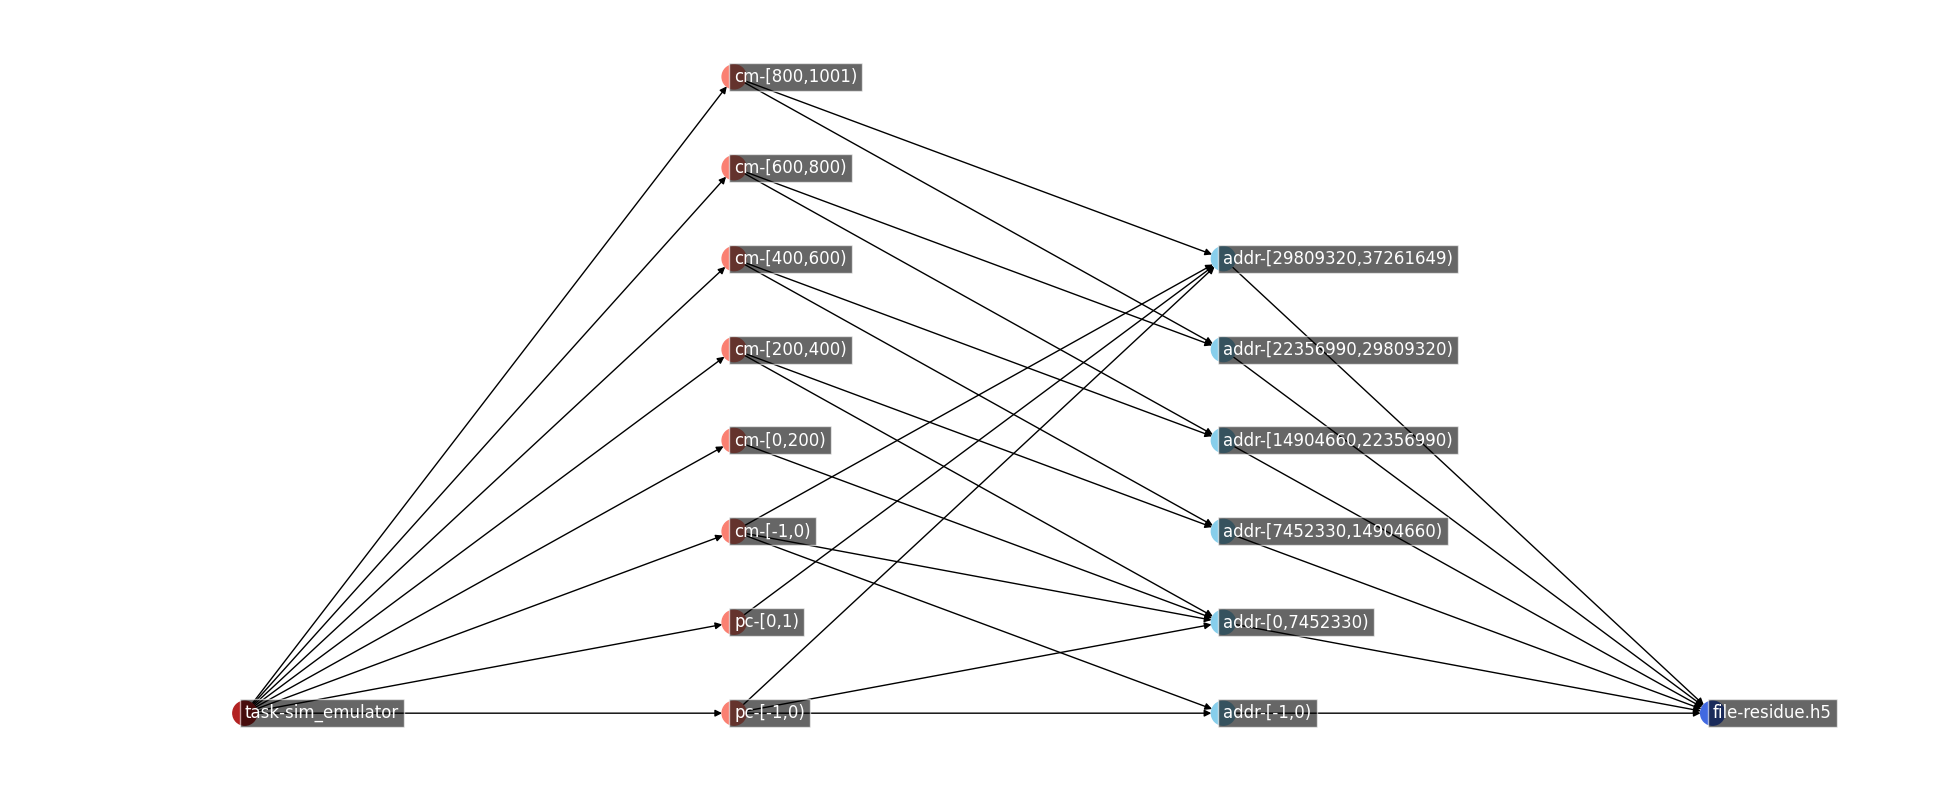

In [35]:
fsim='../save_outputs/vol-vfd/prov-vfd-sim-merged.csv'

df_sim_merged = read_data(fsim)

print(df_sim_merged.columns)

df_sim_merged = split_groups(df_sim_merged,group_cnt)

G_SIM = nx.DiGraph()

add_edges_one2many(G_SIM,df_sim_merged, 'sim_emulator', 'group_vol', x_pos=0, tags=['task','sim-vol'])
add_edges_many2many(G_SIM,df_sim_merged, 'group_vol', 'group_vfd', x_pos=1, tags=['sim-vol','sim-addr'])
add_edges_many2one(G_SIM,df_sim_merged, 'group_vfd', 'residue.h5', x_pos=2, tags=['sim-addr','file'])

draw_graph(G_SIM,COLOR_MAP,rm_tags=['sim'])

Index(['data_label_vol', 'io_access_idx_vol', 'dset_name', 'access_size_vol',
       'op_type_vol', 'logical_addr_vol', 'operation_vol', 'n_elements',
       'dimension_cnt', 'dimensions', 'file_intent', 'layout', 'time(us)_vol',
       'logical_addr_map', 'data_label_vfd', 'io_access_idx_vfd',
       'access_size_vfd', 'op_type_vfd', 'next_addr', 'logical_addr_vfd',
       'file_name', 'time(us)_vfd', 'operation_vfd', 'group_vol',
       'group_rank_vol', 'group_vfd', 'group_rank_vfd'],
      dtype='object')


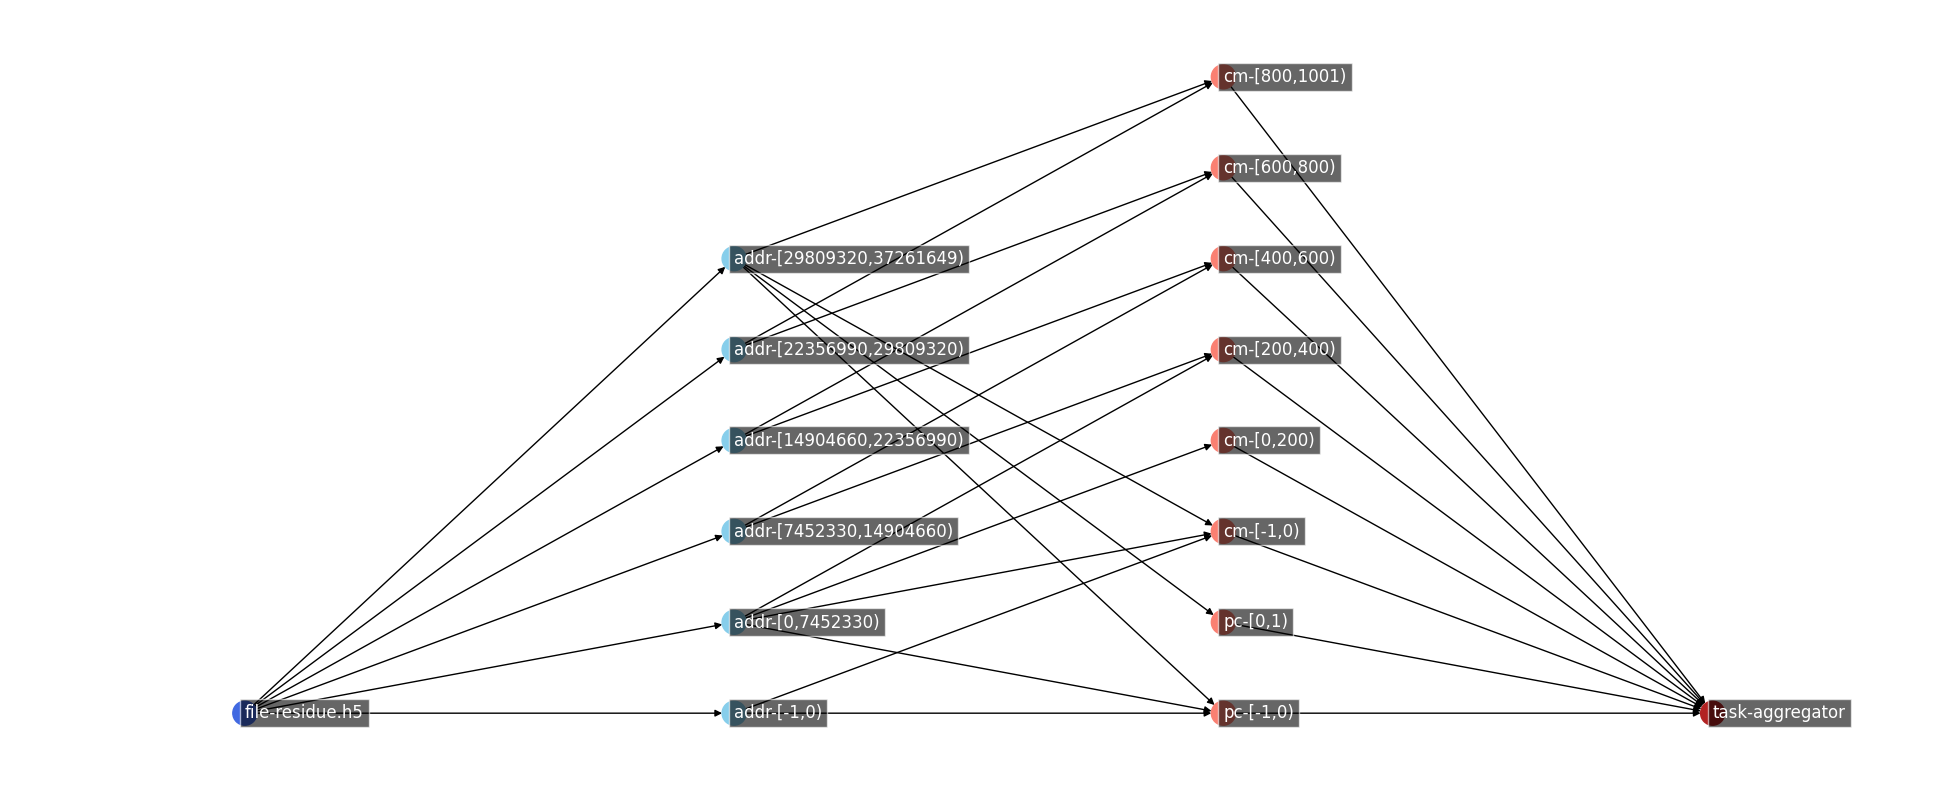

In [36]:
fagg_read='../save_outputs/vol-vfd/prov-vfd-agg-read-merged.csv'

df_agg_read_merged = read_data(fagg_read)

df_agg_read_merged = split_groups(df_agg_read_merged,group_cnt)

print(df_agg_read_merged.columns)


G_AGG_R = nx.DiGraph()
add_edges_one2many(G_AGG_R,df_agg_read_merged, 'residue.h5', 'group_vfd', x_pos=3, tags=['file','agg_r-addr'])
add_edges_many2many(G_AGG_R,df_agg_read_merged, 'group_vfd', 'group_vol', x_pos=4, tags=['agg_r-addr','agg_r-vol'])
add_edges_many2one(G_AGG_R,df_agg_read_merged, 'group_vol', 'aggregator', x_pos=5, tags=['agg_r-vol','task'])

draw_graph(G_AGG_R,COLOR_MAP, rm_tags=['agg_r'])

Index(['data_label_vol', 'io_access_idx_vol', 'dset_name', 'access_size_vol',
       'logical_addr_vol', 'op_type_vol', 'operation_vol', 'n_elements',
       'dimension_cnt', 'dimensions', 'file_intent', 'layout', 'time(us)_vol',
       'logical_addr_map', 'data_label_vfd', 'io_access_idx_vfd',
       'access_size_vfd', 'logical_addr_vfd', 'next_addr', 'op_type_vfd',
       'file_name', 'time(us)_vfd', 'operation_vfd', 'group_vol',
       'group_rank_vol', 'group_vfd', 'group_rank_vfd'],
      dtype='object')


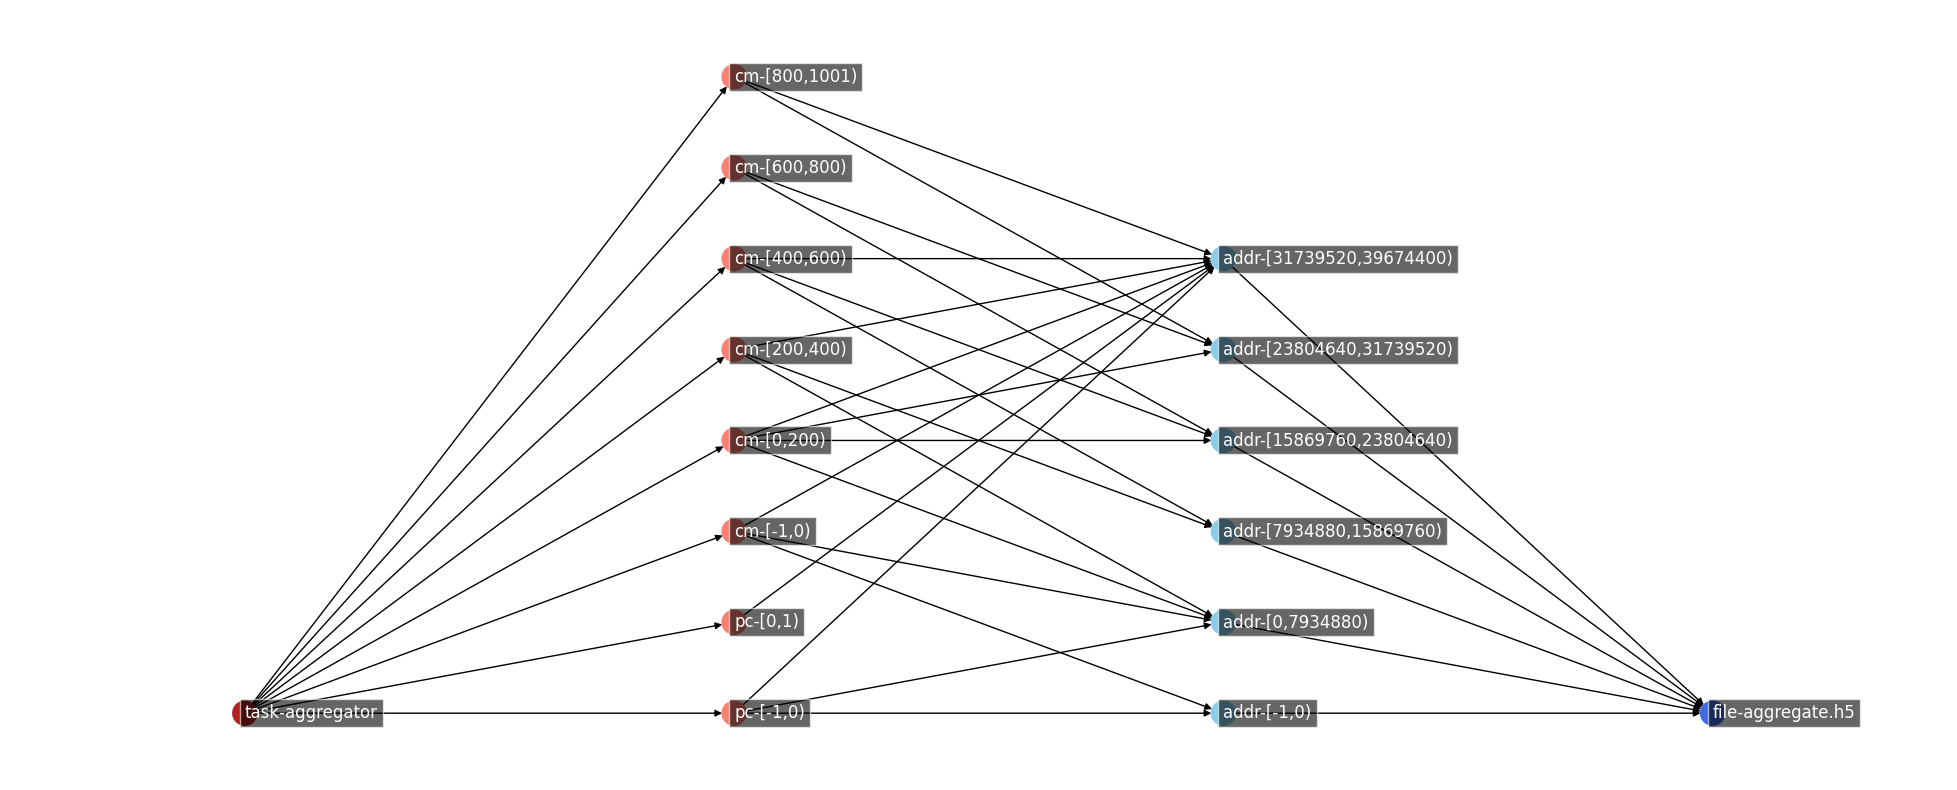

In [40]:
fagg_write='../save_outputs/vol-vfd/prov-vfd-agg-write-merged.csv'

df_agg_write_merged = read_data(fagg_write)
# print(list(df_agg_write_merged['logical_addr_vfd']))

df_agg_write_merged = split_groups(df_agg_write_merged,group_cnt)

print(df_agg_write_merged.columns)



G_AGG_W = nx.DiGraph()
add_edges_one2many(G_AGG_W,df_agg_write_merged, 'aggregator', 'group_vol', x_pos=6, tags=['task','agg_w-vol'])
add_edges_many2many(G_AGG_W,df_agg_write_merged, 'group_vol', 'group_vfd', x_pos=7, tags=['agg_w-vol','agg_w-addr'])
add_edges_many2one(G_AGG_W,df_agg_write_merged, 'group_vfd', 'aggregate.h5', x_pos=8, tags=['agg_w-addr','file'])

draw_graph(G_AGG_W,COLOR_MAP,rm_tags=['agg_w'])


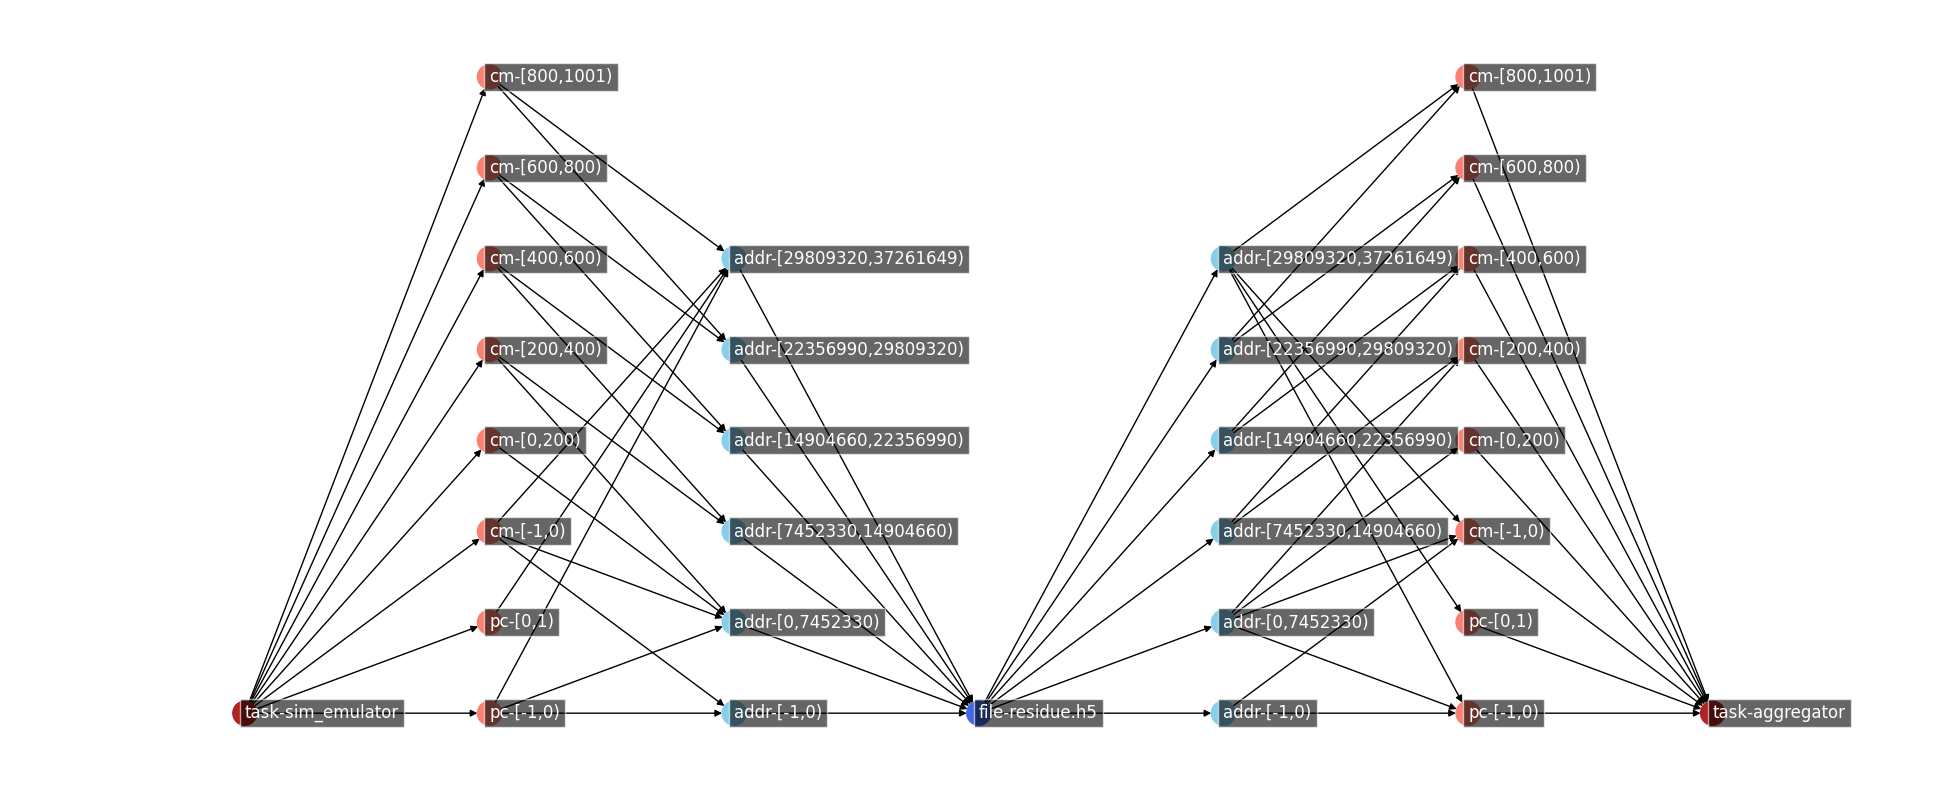

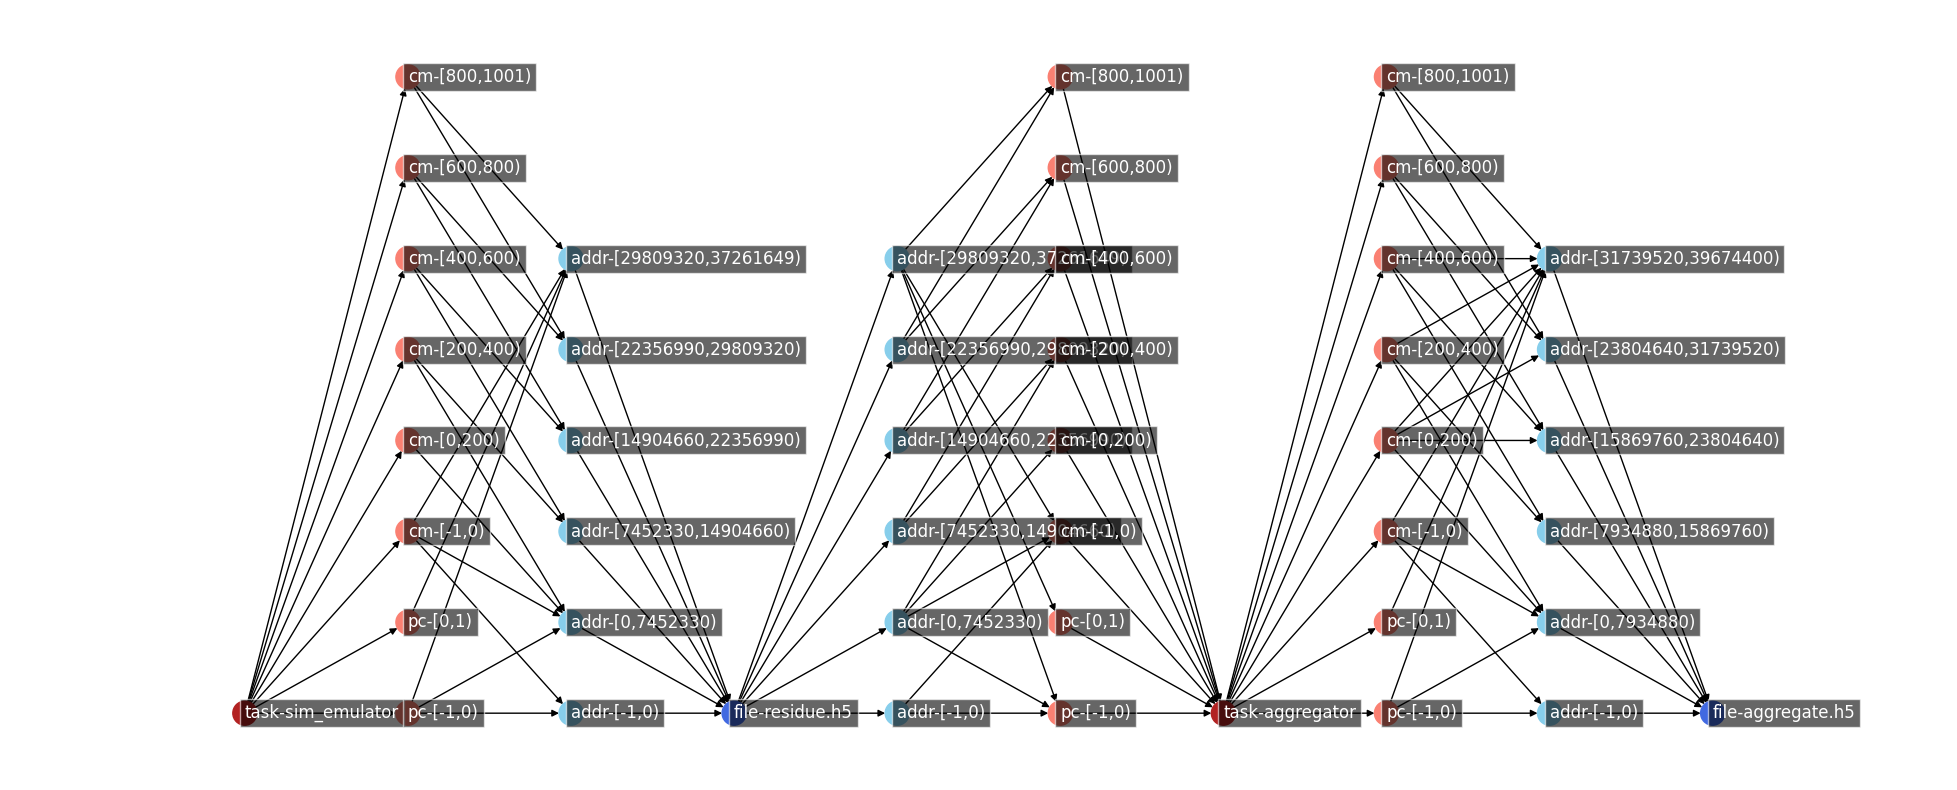

In [41]:
F1 = nx.compose(G_SIM,G_AGG_R)
draw_graph(F1,COLOR_MAP,rm_tags=['sim','agg_r'])

F2 = nx.compose(F1, G_AGG_W)
draw_graph(F2,COLOR_MAP,rm_tags=['sim','agg_r','agg_w'])

In [42]:
# Sankey related codes
# color names: https://www.w3schools.com/colors/colors_names.asp
# EDGE_COLOR_MAP = {"create": "grey", # grey
#             "get": "grey", #grey
#             "open": "grey", # grey
#             "close": "grey", # grey
#             "none": "grey", # grey
#             "read": "Plum", # light megenta
#             "write": "MediumPurple", # light purple
#             }

EDGE_COLOR_MAP = {"create": "rgba(128, 128, 128, 0.4)", # grey
            "get": "rgba(128, 128, 128, 0.4)", #grey
            "open": "rgba(128, 128, 128, 0.4)", # grey
            "close": "rgba(128, 128, 128, 0.4)", # grey
            "none": "rgba(128, 128, 128, 0.4)", # grey
            "read": "rgba(221, 160, 221,0.4)", # light megenta
            "write": "rgba(147, 112, 219, 0.4)", # light purple
            }

def get_xy_position(G):
    pos_dict = nx.get_node_attributes(G,'pos')

    x_dict = {}
    y_dict = {}
    for n, pos in pos_dict.items():
        x_dict[n] = pos[0]
        y_dict[n] = pos[1]
    
    xf=1.0/max(x_dict.values())
    x_pos = {k: v*xf for k, v in x_dict.items() }
    
    yf=1.0/max(y_dict.values())
    y_pos = {k: v*yf for k, v in y_dict.items() }
    # print(x_pos)
    # print(y_pos)
    
    return x_pos, y_pos

def get_nodes_for_sankey(G, rm_tags=[]):
    node_dict_ref = {}
    node_dict_for_sankey = {'label': [], 'color':[], 'x':[], 'y':[] }
    x_pos, y_pos = get_xy_position(G)
    
    for idx, (node_name, attr) in enumerate(G.nodes(data=True)):
        # node_type = 'file' if node_name[-4:] == 'residue_100.h5' else 'task'
        # print(f"{idx}, ({node_name}, {attr})")
        node_type = attr['name']
        if node_name in node_dict_ref:
            print(node_name, "==duplicate==")
        node_dict_ref[node_name] = {'idx':idx, 'type':node_type}

        #sankey
        node_dict_for_sankey['label'].append(rm_name_tags(node_name,rm_tags))
        node_dict_for_sankey['color'].append(COLOR_MAP[rm_name_tags(node_type,rm_tags)])
        node_dict_for_sankey['x'].append(x_pos[node_name])
        node_dict_for_sankey['y'].append(y_pos[node_name])
    return node_dict_for_sankey, node_dict_ref

def get_links_for_sankey(G, node_dict_ref,edge_attr=['access_cnt','access_size','operation'],rm_tags=[]):
    link_dict_for_sankey = {'source':[], 'target':[], 'value':[], 'label': [], 'color': []}
    #'hoverinfo': "all"
    #'line_width':[], # shows strokeWidth of the edges
    
    attr_cnt = nx.get_edge_attributes(G,edge_attr[0])
    attr_size = nx.get_edge_attributes(G,edge_attr[1])
    attr_op = nx.get_edge_attributes(G,edge_attr[2])
    
    min_size = min(attr_size.values())
    
    # print(attr_dict)
    for u, v, attr in G.edges(data=True):
        # print(u, v, attr)
        u_idx = node_dict_ref[u]['idx']
        v_idx = node_dict_ref[v]['idx']
        link_dict_for_sankey['source'].append(u_idx)
        link_dict_for_sankey['target'].append(v_idx)
        
        # print(ops)
        # link_dict_for_sankey['value'].append(attr['weight])
        
        cnt = attr_cnt[(u,v)]
        size = attr_size[(u,v)]
        if cnt == 0: cnt = 1
        if size == 0: 
            size = 1
            op = 'meta'
        else:
            op = attr_op[(u,v)]
        
        if op == 'open' or op == 'close':
            size = 1
        
        link_dict_for_sankey['color'].append(EDGE_COLOR_MAP[op]) # get the last operation
        link_dict_for_sankey['value'].append(size)
        _str = f"ave_acc_size: {humansize(size/cnt)} op: {op}"
        link_dict_for_sankey['label'].append(_str)
        # link_dict_for_sankey['acc_cnt'].append(cnt)
        
    return link_dict_for_sankey

def selected_graph(node_name, G):
    # this is not used
    selected_G = nx.DiGraph()
    search_nodes = [node_name]
    while len(search_nodes) > 0:
        next_set = []
        for n in search_nodes:
            for edge in G.edges(n):
                val = G.edges[edge]['value']
                selected_G.add_edges_from([edge], value=val)
                #print(selected_G.nodes)
            next_set += [x for x in G.neighbors(n)]
        search_nodes = next_set
    return selected_G

In [43]:
sim_nodes, sim_nodes_dict = get_nodes_for_sankey(G_SIM, rm_tags=['sim'])

# print(node_ref2)

sim_links = get_links_for_sankey(G_SIM, sim_nodes_dict)
fig = go.Figure(go.Sankey(
            node = sim_nodes,
            link = sim_links, orientation='h'))
fig.show()
fig.write_html(f"{path}/sankey-grouped-sim_w-vol-vfd-.html")

In [44]:
AGG = nx.compose(G_AGG_R, G_AGG_W) 

agg_nodes, agg_nodes_dict = get_nodes_for_sankey(AGG,rm_tags=['agg_r','agg_w'])

agg_links = get_links_for_sankey(AGG, agg_nodes_dict)
fig = go.Figure(go.Sankey(
            node = agg_nodes,
            link = agg_links, orientation='h'))
fig.show()
fig.write_html(f"{path}/sankey-grouped-agg-vol-vfd.html")

In [45]:
f2_nodes, f2_nodes_dict = get_nodes_for_sankey(F2,rm_tags=['sim','agg_r','agg_w'])

# print(node_ref2)

f2_links = get_links_for_sankey(F2, f2_nodes_dict)
fig = go.Figure(go.Sankey(
            node = f2_nodes,
            link = f2_links, orientation='h'))
fig.show()
fig.write_html(f"{path}/sankey-grouped-sim_w_agg_r_w-vol-vfd.html")